In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline

# Uniform Distribution

A uniform distribution is one that has a flat PDF, and so each value has an equal likelyhood of occuring.

In [2]:
def randomUniformNumbers(num_samples, dimensions, lower_bound, upper_bound):
    """
    Generates an array of uniformly distributed random numbers.

    Parameters
    ----------
    num_samples : int
        Number of random samples (rows) to generate.
    dimensions : int
        Number of dimensions for each sample (columns).
    lower_bound : float
        Lower bound of the uniform distribution.
    upper_bound : float
        Upper bound of the uniform distribution.

    Returns
    -------
    numpy.ndarray
        A (num_samples x dimensions) array of uniformly distributed random numbers.
    """
    random_array = []
    for _ in range(num_samples):
        random_array.append(np.random.uniform(lower_bound, upper_bound, dimensions))
    return np.array(random_array)


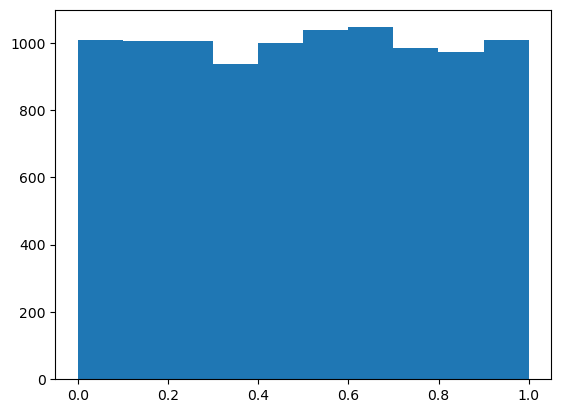

In [3]:
plt.hist(randomUniformNumbers(10000,1,0,1))
plt.show()

# Expanding Uniform Distribution to 3D

The uniform distribution in 3D should form a filled cube.<br>
There are no spectral gaps present.

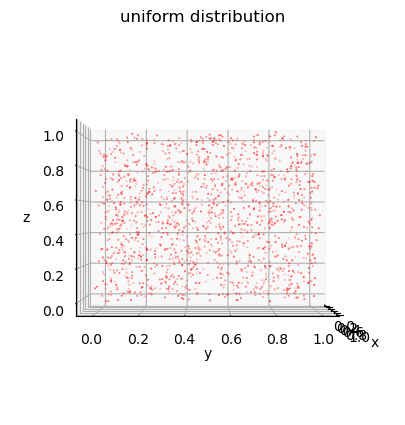

In [4]:
def plotting3D(x, y, z, elev, azim, roll, title):
    """
    Creates a 3D scatter plot of the given coordinates and adjusts the camera view.

    Parameters
    ----------
    x : array-like
        x-coordinates of data points in 3D space.
    y : array-like
        y-coordinates of data points in 3D space.
    z : array-like
        z-coordinates of data points in 3D space.
    elev : float
        Elevation angle in degrees (rotation around the x-axis).
    azim : float
        Azimuthal angle in degrees (rotation around the z-axis).
    roll : float
        Roll angle in degrees (rotation around the y-axis).
    title : str
        Title of the plot.

    Returns
    -------
    None
        Displays a 3D scatter plot using matplotlib.
    """
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, color='r', s=0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=elev, azim=azim, roll=roll)
    plt.title(title)
    plt.show()

uniformData=randomUniformNumbers(1500,3,0,1)
plotting3D(uniformData[:,0],uniformData[:,1],uniformData[:,2],*[0,0,0],'uniform distribution')

# Linear Congruential Generator (LCG)

This is the most basic example of a psudo-random number generator.<br>
You start with a seed number and generate a sequence of numbers that appears random: $X_{n+1}=(aX_n+c)$ $mod$ $m$.<br>
This function works according to the following constaints:<br>
$0<m$<br>
$0\leq a<m$<br>
$0<c<m$<br>
$0\leq X_0<m$<br>

This sequence is then also normalised to be between 0 and 1 using the expression:$s_n=\frac{X_n}{m}$<br>

The problem with LCGs is that they produce spectral lines which show correlation between points, and therefore aren't good approximations of randomness.

In [5]:
def randssp(p, q):
    """
    Generates a p-by-q array of pseudo-random numbers using a linear congruential generator (LCG).

    Parameters
    ----------
    p : int
        Number of rows of the final array.
    q : int
        Number of columns of the final array.

    Returns
    -------
    r : ndarray
        A (p x q) NumPy array of pseudo-random numbers between 0 and 1.
    """
    global m, a, c, x
    try:
        x
    except NameError:
        m = 2**31            # Modulus
        a = 2**16 + 3        # Multiplier
        c = 0                # Increment
        x = 123456789        # Seed

    r = np.zeros([p, q])
    for l in range(q):
        for k in range(p):
            x = np.mod(a * x + c, m)
            r[k, l] = x / m

    return r

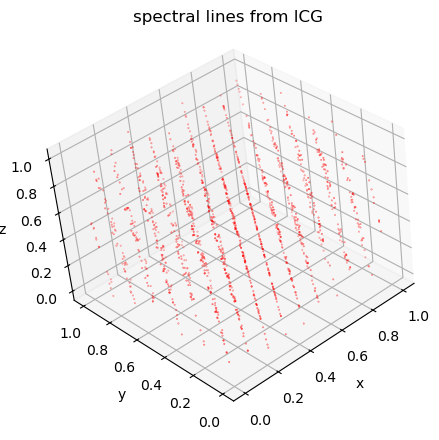

In [6]:
plotting3D(*randssp(3,1500),34,-128,7,'spectral lines from lCG')

# Cumulative distribution sampling with exponential distribution

We can use the method of inverse/cumulative distribution sampling to randomly sample data from a distribution.<br>

If we start with a Probaility density function, in this case $P(x)=e^{-\frac{x}{\lambda}}$, then we can determine both the cumulative probability distribution and the inverse CDF as: $CDF(x)=\lambda(1-e^{-\frac{x}{\lambda}})$, $CDF^{-1}(x)=-\lambda \ln({1-\frac{x}{\lambda})}$.<br>

By generating a random uniform distribution of values, and then using $X=CDF^{-1}(u_i)$, $X$ is then a dataset in the form of the CDF distribution but distributed according to the PDF.<br>

This is shown in the 3 plots bellow, where we can see how the points in the 3rd plot are distributed according to the first.

/tmp/ipykernel_204/2233592167.py:47: RuntimeWarning: invalid value encountered in log
  return -(mfp) * np.log(data)


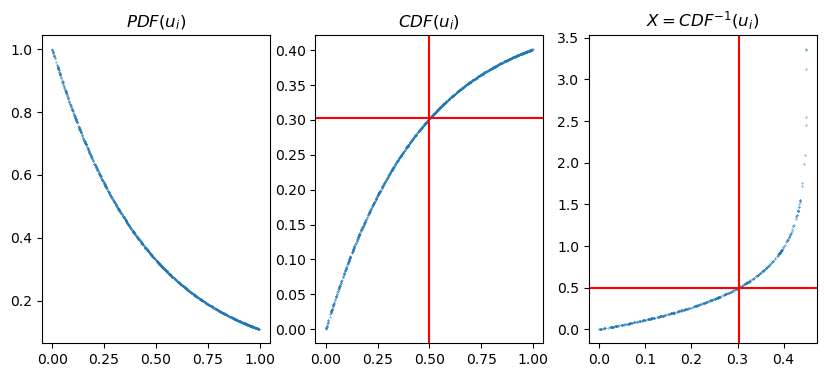

In [7]:
class cumulative_sampling:
    """
    A class to compute properties related to neutron transport using cumulative sampling.

    Attributes:
        p (float): Density of the material (g/cm^3).
        M (float): Molar mass of the material (g/mol).
        acs (float): Microscopic cross-section (cm^2).
        n (float): Number density (atoms/cm^3).
    """
    def __init__(self, p, M, acs):
        """
        Initializes the cumulative_sampling object.

        Parameters:
            p (float): Density of the material (g/cm^3).
            M (float): Molar mass of the material (g/mol).
            acs (float): Microscopic cross-section (cm^2).
        """
        self.p = p
        self.M = M
        self.acs = acs  
        self.n = (self.p * 6.02 * 10**23) / self.M

    def meanFreePath(self):
        """
        Calculates the mean free path of a neutron in the material.

        Returns:
            float: Mean free path (cm).
        """
        Macro_crossSection = self.n * self.acs
        return 1 / Macro_crossSection


def cdf_inverse(data, mfp):
    """
    Applies the inverse cumulative distribution function for the exponential distribution.

    Parameters:
        data (array-like): Uniformly distributed random values between 0 and 1.
        mfp (float): Mean free path (scale parameter of the exponential distribution).

    Returns:
        array-like: Samples from the exponential distribution.
    """
    return -(mfp) * np.log(data)


def exponential(x, A, k):
    """
    Exponential function of the form A * exp(-x / k).

    Parameters:
        x (float or array-like): Input value(s).
        A (float): Amplitude of the exponential function.
        k (float): Decay constant (e.g., mean free path).

    Returns:
        float or array-like: Result of the exponential function.
    """
    return A * np.exp(-x / k)
    
Cumulative_demonstration=cumulative_sampling(1000,0.0180153,0.6652*10**-28)
mfp=Cumulative_demonstration.meanFreePath()
x_data=randomUniformNumbers(1000,1,0,1)
plt.subplots(1,3,figsize=(10,4))
plt.subplot(1,3,1)
plt.scatter(x_data,exponential(x_data,1,mfp),s=0.1)
plt.title('$PDF(u_i)$')
plt.subplot(1,3,2)
y_data=(mfp)*(1-exponential(x_data,1,mfp))
plt.scatter(x_data,y_data,s=0.1)
plt.axvline(0.5,color='r')
d=np.absolute(0.5-x_data)
plt.axhline(y_data[np.argmin(d)],color='r')
plt.title('$CDF(u_i)$')
plt.subplot(1,3,3)
y_data=cdf_inverse(1-x_data/mfp,mfp)
mask=~np.isnan(y_data)
y_data=y_data[mask]
x_data=x_data[mask]
plt.scatter(x_data,y_data,s=0.1)
plt.axhline(0.5,color='r')
d=np.absolute(0.5-y_data)
plt.axvline(x_data[np.argmin(d)],color='r')
#plt.xlim(0,0.45)
plt.title('$X=CDF^{-1}(u_i)$')
plt.show()

Since $u_i$ is a randomly generated value, $1-\frac{u_i}{\lambda}$ is also a random number, so we can change the $CDF^{-1}$ to $CDF^{-1}=-\ln({1-u_i})$, and using this we can randomly generate our data distributed according to the $PDF$.<br>

We can then generate multiple histograms of this $CDF^{-1}$ data, and average the bins of each to give an average bin size plot. Since a histogram describes the density of each bin, the shape of the average plot will be the original $PDF$. This can then be fitted to and the mean free path, $\lambda$, can be found.

attenuation length is found to be: 44.83006438802308 cm


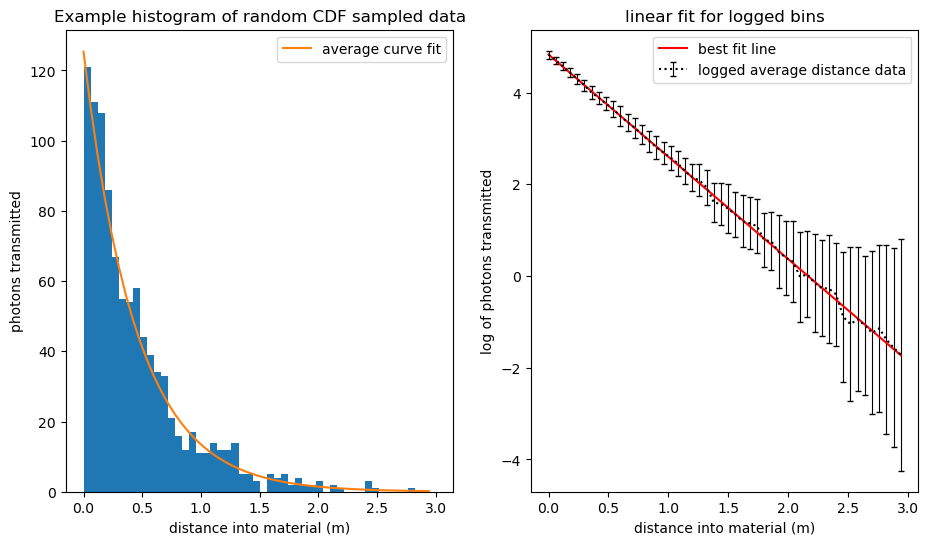

In [8]:
data=np.zeros((100,50))
for i in range(100):
    x_data=randomUniformNumbers(1000,1,0,1)
    bins,bin_edges=np.histogram(cdf_inverse(x_data,mfp),bins=50,range=(0,3))
    data[i]=bins
plt.subplots(1,2,figsize=(11,6))
plt.subplot(1,2,1)
plt.title('Example histogram of random CDF sampled data')
plt.xlabel('distance into material (m)')
plt.ylabel('photons transmitted')
errors=np.std(data,axis=0)
data=np.mean(data,axis=0)
plt.hist(cdf_inverse(x_data,mfp),bins=50,range=(0,3))
plt.subplot(1,2,2)
plt.title('linear fit for logged bins')
plt.xlabel('distance into material (m)')
plt.ylabel('log of photons transmitted')
plt.errorbar(bin_edges[:-1],np.log(data),errors/data,linestyle='dotted',capsize=2,elinewidth=0.8,color='k',label='logged average distance data')
polv,covr=np.polyfit(bin_edges[:-1],np.log(data),w=data/errors,deg=1,cov=True)
plt.plot(bin_edges[:-1],polv[0]*bin_edges[:-1]+polv[1],color='r',label='best fit line')
print('attenuation length is found to be: {} cm'.format(-1/polv[0]*10**2))
plt.legend()

plt.subplot(1,2,1)
plt.plot(bin_edges[:-1],np.exp(polv[1])*np.exp(polv[0]*bin_edges[:-1]),label='average curve fit')
plt.legend()

plt.show()

### Isotropic Unit vectors

we can generate random uniform distributions for the three spherical polar coordinates, and then use them to make an isotropic vector of length 1 using the equations:<br>
$x=r\sin(\theta)\cos(\phi)$<br>
$y=r\sin(\theta)\sin(\phi)$<br>
$z=r\cos(\theta)$<br>

The range for $\theta$ and $\phi$ are usually $0\leq\theta\leq\pi$ and $0\leq\phi\leq2\pi$, bu this leads to concentration of points at the poles of the sphere.<br>
This can be fixed by scaling the values of $\theta$ so that there are less at the poles, which can be done with: $\theta=\arccos(1-2u_i)$, where $u_i$ is our uniformally generated random data.

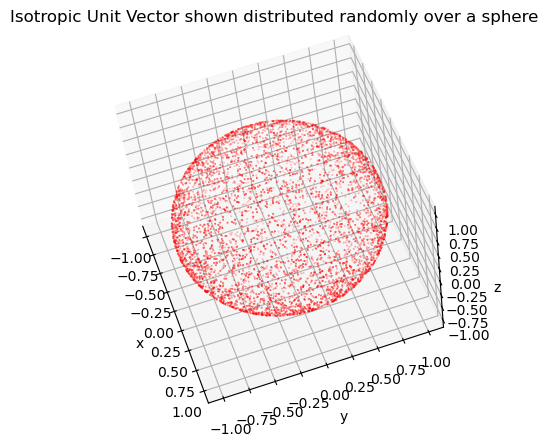

In [9]:
def generate_isotropic_unit_vectors(num_vectors, min_radius, max_radius):
    """
    Generates isotropically distributed unit vectors in spherical coordinates.

    Parameters
    ----------
    num_vectors : int
        Number of random vectors to generate.
    max_radius : float
        Maximum radius for the generated vectors.

    Returns
    -------
    tuple of numpy.ndarray
        A tuple (radius, theta, phi) where:
        - radius : Array of radii sampled uniformly in [min_radius, max_radius]
        - theta  : Array of polar angles (colatitude) in [0, π]
        - phi    : Array of azimuthal angles in [0, 2π]
    """
    radius=randomUniformNumbers(num_vectors,1,min_radius,max_radius)
    theta=np.arccos(1-2*randomUniformNumbers(num_vectors,1,0,1))
    phi=randomUniformNumbers(num_vectors,1,0,2*np.pi)
    return radius,theta,phi
radius,theta,phi=generate_isotropic_unit_vectors(5000,1,1)
x_values=radius*np.sin(theta)*np.cos(phi)
y_values=radius*np.sin(theta)*np.sin(phi)
z_values=radius*np.cos(theta)
plotting3D(x_values,y_values,z_values,49,-11,9,'Isotropic Unit Vector shown distributed randomly over a sphere')

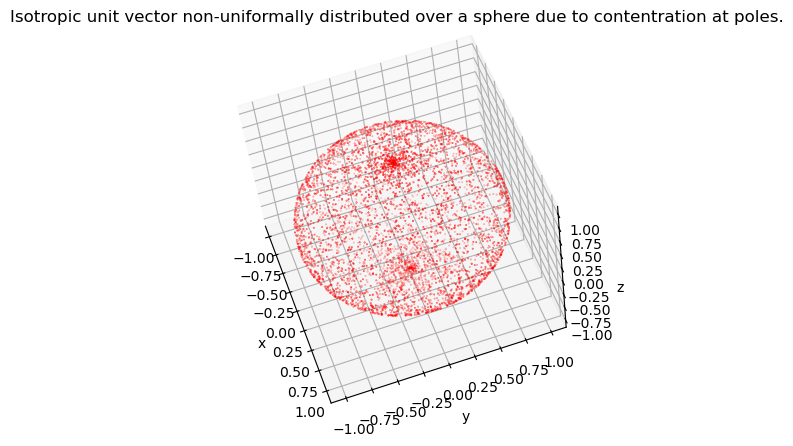

In [10]:
theta=randomUniformNumbers(5000,1,0,np.pi)
x_values=radius*np.sin(theta)*np.cos(phi)
y_values=radius*np.sin(theta)*np.sin(phi)
z_values=radius*np.cos(theta)
plotting3D(x_values,y_values,z_values,49,-11,9,'Isotropic unit vector non-uniformally distributed over a sphere due to contentration at poles.')

# Isotropic attenuated vectors

Using the aforementioned process of cumulative distribution sampling, we can create isotropic vectors that attenuate with increasing radius

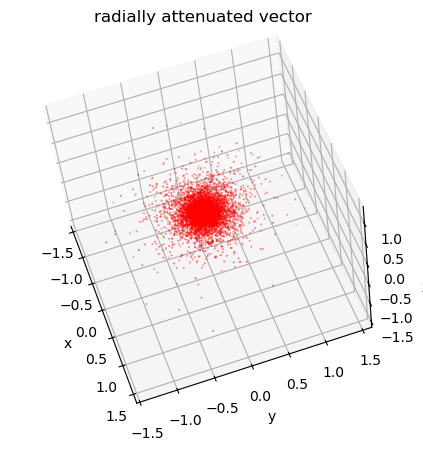

In [11]:
def isotropic_exponential(n,mfp):
    """
    Generates 3D coordinates sampled from an isotropic exponential distribution.

    Parameters:
    ----------
    n : int
        Number of samples to generate.
    mfp : float
        Mean free path (λ), used as the scale parameter in the exponential distribution.

    Returns:
    -------
    x_values : ndarray
        Array of x-coordinates of the sampled points.
    y_values : ndarray
        Array of y-coordinates of the sampled points.
    z_values : ndarray
        Array of z-coordinates of the sampled points.
    """
    
    radius,theta,phi=generate_isotropic_unit_vectors(n,0,1)
    radius2=cdf_inverse(radius,mfp)
    x_values=radius2*np.sin(theta)*np.cos(phi)
    y_values=radius2*np.sin(theta)*np.sin(phi)
    z_values=radius2*np.cos(theta)
    return x_values,y_values,z_values
plotting3D(*isotropic_exponential(10000,0.2),49,-11,9,'radially attenuated vector')

# Monte Carlo Method for scattering through different materials

We can simulate the scattering of neutrons through a material by performing random walks with probabilities distributed according to the mean free path attributed to the material using the CDF sampling method.

In [12]:
Pb_absorption_cs=0.158*10**-24
Pb_scattering_cs=11.221*10**-24
H2O_absorption_cs=0.6652*10**-24
H2O_scattering_cs=103.0*10**-24
Graphite_absorption_cs=0.0045*10**-24
Graphite_Scattering_cs=4.74*10**-24


class attenuation(cumulative_sampling):
    """
    A subclass of cumulative_sampling that adds support for scattering processes
    in neutron transport calculations.

    This class calculates macroscopic absorption and scattering cross-sections,
    as well as the mean free path accounting for both interactions.

    Attributes
    ----------
    scs : float
        Microscopic scattering cross-section (cm^2).
    name : str
        Identifier or label for the material or model.
    acs : float
        Microscopic absorption cross-section (inherited).
    n : float
        Number density of atoms (atoms/cm^3), computed from density and molar mass (inherited).
    """

    def __init__(self, p, M, acs, scs, name):
        """
        Initializes the attenuation object with both absorption and scattering data.

        Parameters
        ----------
        p : float
            Density of the material (g/cm^3).
        M : float
            Molar mass of the material (g/mol).
        acs : float
            Microscopic absorption cross-section (cm^2).
        scs : float
            Microscopic scattering cross-section (cm^2).
        name : str
            Descriptive name of the material or model.
        """
        self.scs = scs
        self.name = name
        super().__init__(p, M, acs)

    def Macro_cs(self):
        """
        Computes the macroscopic absorption and scattering cross-sections.

        Returns
        -------
        tuple of float
            (macroscopic absorption, macroscopic scattering), calculated as:
            (n * acs, n * scs)
        """
        return self.n * self.acs, self.n * self.scs

    def meanFreePath(self):
        """
        Calculates the mean free path accounting for both absorption and scattering.

        Overrides:
        ---------
        cumulative_sampling.meanFreePath

        Returns
        -------
        float
            Mean free path (cm), given by 1 / (n * (acs + scs))
        """
        Total_Macro_CrossSection = self.n * (self.acs + self.scs)
        return 1 / Total_Macro_CrossSection

    def writing_name(self):
        """
        Returns the name of the material or model.

        Returns
        -------
        str
            The `name` attribute.
        """
        return self.name

Pb=attenuation(11.35,207.2,Pb_absorption_cs,Pb_scattering_cs,'Lead')
H2O=attenuation(1,18.0153,H2O_absorption_cs,H2O_scattering_cs,'Water')
Graphite=attenuation(1.67,12.011,Graphite_absorption_cs,Graphite_Scattering_cs,'Graphite')

material_Objects=np.array([H2O,Pb,Graphite])
probabilities=[]
mfps=[]
for o in material_Objects:
    Mcs=o.Macro_cs()
    Scattering_Prob=Mcs[1]/np.sum(Mcs)
    Absorption_Prob=Mcs[0]/np.sum(Mcs)
    mfp=o.meanFreePath()
    probabilities.append((Scattering_Prob,Absorption_Prob))
    mfps.append(mfp)
probabilities=np.array(probabilities)

In [13]:

def draw_3d_cube(x_range, y_range, z_range):
    """
    Draws a wireframe 3D cube using the specified axis-aligned ranges.

    Parameters
    ----------
    x_range : tuple of float
        (min, max) limits along the X-axis in centimeters.
    y_range : tuple of float
        (min, max) limits along the Y-axis in centimeters.
    z_range : tuple of float
        (min, max) limits along the Z-axis in centimeters.

    Returns
    -------
    None
        Creates a cube.
    """
    plt.close('all')
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=15, azim=-66, roll=0)

    # Define vertices of the cube
    vertices = np.array([
        [x_range[0], y_range[0], z_range[0]],
        [x_range[0], y_range[0], z_range[1]],
        [x_range[0], y_range[1], z_range[0]],
        [x_range[0], y_range[1], z_range[1]],
        [x_range[1], y_range[0], z_range[0]],
        [x_range[1], y_range[0], z_range[1]],
        [x_range[1], y_range[1], z_range[0]],
        [x_range[1], y_range[1], z_range[1]],
    ])

    # Define the six cube faces (each face is a list of 4 vertices)
    faces = [
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Bottom
        [vertices[7], vertices[6], vertices[2], vertices[3]],  # Top
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Left
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Right
        [vertices[1], vertices[5], vertices[7], vertices[3]],  # Front
        [vertices[0], vertices[4], vertices[6], vertices[2]],  # Back
    ]

    # Draw the cube
    ax.add_collection3d(Poly3DCollection(faces, linewidths=1, edgecolors='r', alpha=0))

    # Set axis labels and limits
    ax.set_xlabel('X $[cm]$')
    ax.set_ylabel('Y $[cm]$')
    ax.set_zlabel('Z $[cm]$')
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_zlim(z_range)

    plt.show()

In [14]:
def attenuation_through_material(material_Objects,number,L,size,steps):
    """
    Simulates particle transport through a slab of material using Monte Carlo methods.

    Particles are launched isotropically into the material, and their trajectories
    are tracked until they are either absorbed, reflected, or transmitted. The simulation
    records particle paths over a number of steps.

    Parameters
    ----------
    material_Objects : list of attenuation
        List of material models (instances of the `attenuation` class).
    number : int
        Index (1-based) of the material in `material_Objects` to simulate.
    L : float
        Length of the material slab along the x-axis [cm].
    size : int
        Number of particles to simulate.
    steps : int
        Maximum number of steps each particle can take.

    Returns
    -------
    x_data : ndarray
        Array of x-coordinates with shape (steps+1, size), recording each particle's path.
    y_data : ndarray
        Array of y-coordinates with shape (steps+1, size), recording each particle's path.
    z_data : ndarray
        Array of z-coordinates with shape (steps+1, size), recording each particle's path.
    absorbed_counter : int
        Total number of particles absorbed in the material.
    reflected_counter : int
        Total number of particles reflected (x < 0).
    transmitted_counter : int
        Total number of particles transmitted through the material (x > L).
    """
    absorbed_counter=0
    reflected_counter=0
    transmitted_counter=0
    coordinates=np.zeros((4,size))
    coordinates[3]=True
    probs=material_Objects[number-1].Macro_cs()
    Scattering_Prob=probs[1]/sum(probs)
    Absorption_Prob=probs[0]/sum(probs)
    mfp=material_Objects[number-1].meanFreePath()
    particle_history=np.zeros((3,steps,size))
    step=0
    coordinates[0]=abs(isotropic_exponential(size,mfp)[0].ravel())
    while coordinates[3].any()!=False:
        random_step=isotropic_exponential(size,mfp)
        out=np.argwhere(coordinates[3]==False)
        for i in range(0,3):
            coordinates[i]+=random_step[i].ravel()
            particle_history[i][step]=coordinates[i].ravel()
            for n in range(len(particle_history[i][step])):
                if step==0:
                    break
                if particle_history[i][step-1][n]==False:
                    particle_history[i][step][n]=None
            for o in out:
                particle_history[i][step][o[0]]=None
        u=randomUniformNumbers(size,1,0,1)
        #checking is in box
        proceeded=np.argwhere(coordinates[0]<0)
        exceeded=np.argwhere(coordinates[0]>L)
        if len(proceeded)!=0 or len(exceeded)!=0:
            for p in proceeded:
                if coordinates[3][p[0]]!=False:
                    reflected_counter+=1
                    coordinates[3][p[0]]=False
            for e in exceeded:
                if coordinates[3][e[0]]!=False:
                    transmitted_counter+=1
                    coordinates[3][e[0]]=False
        absorbed=np.argwhere(u<Absorption_Prob)
        if len(absorbed)!=0:
            for a in absorbed:
                if coordinates[3][a[0]]!=False:
                    absorbed_counter+=1
                    coordinates[3][a[0]]=False
        if step<steps-1:
            step+=1
        else:
            break
    x_data=np.zeros((steps+1,size))
    y_data=np.zeros((steps+1,size))
    z_data=np.zeros((steps+1,size))
    for x in range(len(x_data)-1):
        x_data[x+1]=particle_history[0][x].ravel()
        y_data[x+1]=particle_history[1][x].ravel()
        z_data[x+1]=particle_history[2][x].ravel()
    return x_data,y_data,z_data,absorbed_counter,reflected_counter,transmitted_counter


# Visualising thermal neutron travel

The paths of the neutrons as they move through the materials can be plotted and shown as lines through a cuboid.
There are 10 neutrons being attenuated in each plot, and although there are limits on the dimentions of the material in y and z direction in the plot, we are assuming a slab of finite x-thickness but infinite y and z thicknesses.<br>

The steps the neutrons take are determined using the process described in generating the isotropic attenuated vector, so the steps the neutrons take are distributed according to a PDF with the mean free path for the material inputted.

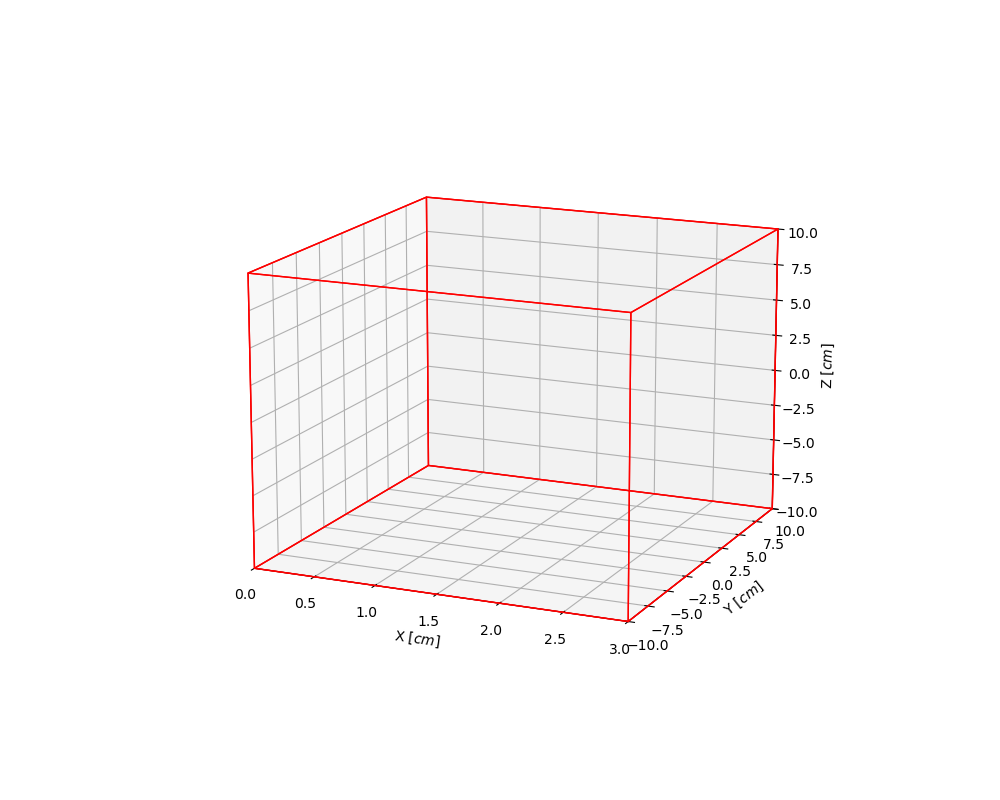

2001


In [23]:
%matplotlib widget
L=3
N=10
x_range = [0, L]  # x-axis from -5 to 5
y_range = [-10, 10]  # y-axis from -3 to 3
z_range = [-10, 10]  # z-axis from -2 to 2
number=1
particle_trajectory=attenuation_through_material(material_Objects,number,L,N,2000)
draw_3d_cube(x_range, y_range, z_range)
plt.title('Neutron random walks through {}'.format(material_Objects[number-1].writing_name()))
print(len(particle_trajectory[0]))
for i in range(N-1):
     plt.plot(particle_trajectory[0][:,i],particle_trajectory[1][:,i],particle_trajectory[2][:,i])

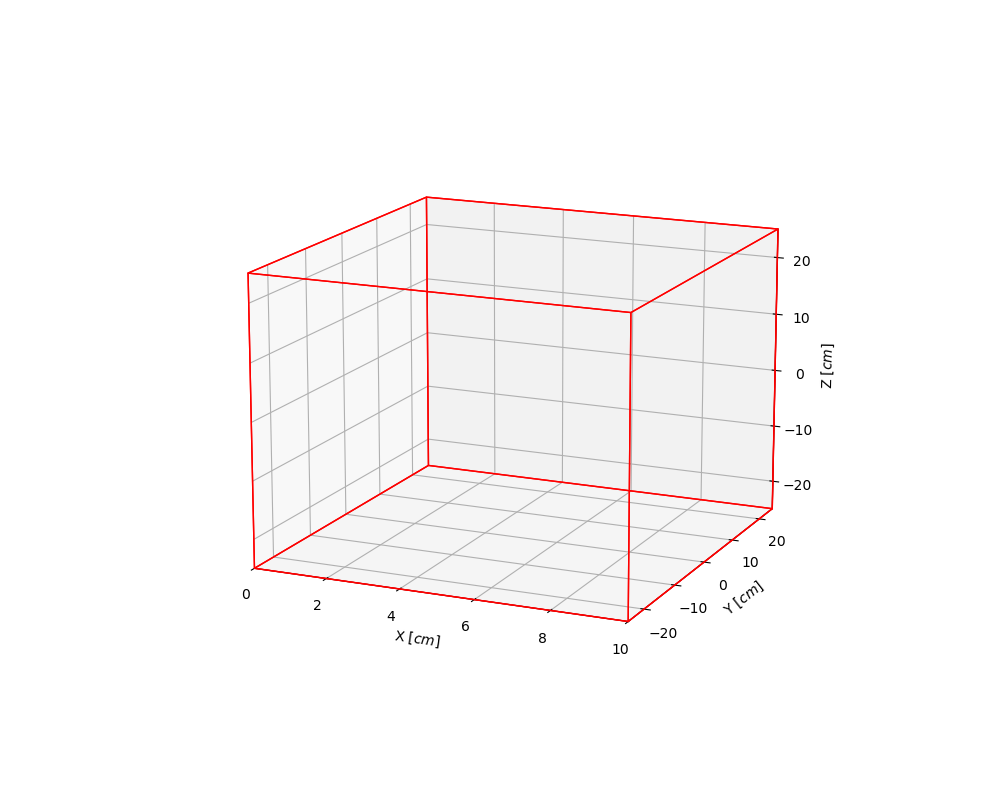

In [24]:
L=10
x_range = [0,L]  # x-axis from -5 to 5
y_range = [-25, 25]  # y-axis from -3 to 3
z_range = [-25, 25]  # z-axis from -2 to 2
number=2
particle_trajectory=attenuation_through_material(material_Objects,number,L,N,2000)
draw_3d_cube(x_range, y_range, z_range)

plt.title('Neutron random walks through {}'.format(material_Objects[number-1].writing_name()))
for i in range(N-1):
    plt.plot(particle_trajectory[0][:,i],particle_trajectory[1][:,i],particle_trajectory[2][:,i])
plt.draw()

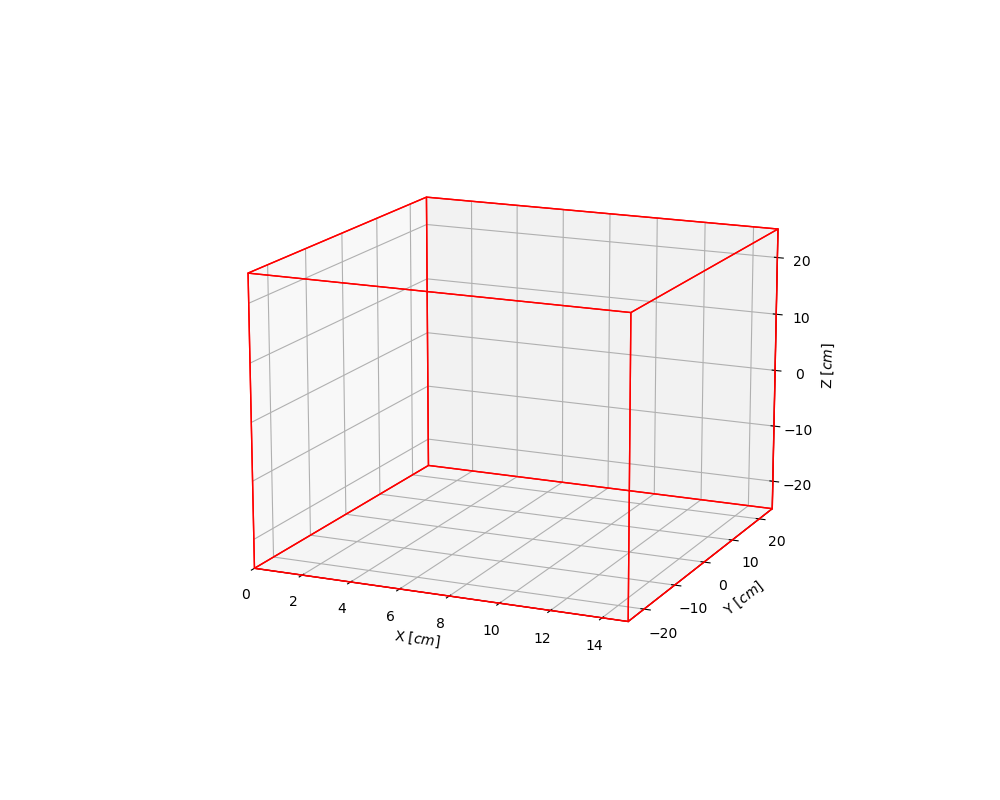

In [25]:
L=15
x_range = [0,L]  # x-axis from -5 to 5
y_range = [-25, 25]  # y-axis from -3 to 3
z_range = [-25, 25]  # z-axis from -2 to 2
number=3
particle_trajectory=attenuation_through_material(material_Objects,number,L,N,20)
draw_3d_cube(x_range, y_range, z_range)
plt.title('Neutron random walks through {}'.format(material_Objects[number-1].writing_name()))
for i in range(N-1):
     plt.plot(particle_trajectory[0][:,i],particle_trajectory[1][:,i],particle_trajectory[2][:,i])

# Thermal neutron travel without visualisation

Removing the visualisation allows us to greatly improve the speed of simulating the neutron travel, as it allows us to remove reduntancy from our program.<br>
All iteration is removed and replaced by vectorisation and boolean masking, as iteration causes a large time complexity.<br>

The neutrons that are either reflected, transmitted or absorbed are dont continue to be logged and this causes the time complexity to go from $\mathcal{O}(Neutrons \times Steps)$ to $\mathcal{O}(Neutrons \times \overline{Steps})$, where $\overline{Steps}$ is the average number of steps a particle takes, which is a lot smaller than the total number of steps to attenuate all the neutrons.

In [18]:
%matplotlib inline
def new_step(mfp,n):
    """
    Generates random steps for particles based on an exponential distribution for 
    step lengths and uniform spherical sampling for direction.

    Parameters
    ----------
    mfp : float
        Mean free path of the material (cm), used to scale the exponential distribution for the step lengths.
    n : int
        Number of steps to generate (number of particles).

    Returns
    -------
    x : ndarray
        Array of x displacements for each of the `n` particles, generated from an exponential distribution and isotropic directions.
    """
    x=-mfp*np.log(np.random.uniform(0,1,n))*np.sqrt(1-np.random.uniform(-1,1,n)**2)*np.cos(np.random.uniform(0,2*np.pi,n))
    return x

def attenuation_through_material_without_graph_data(parameters):
    """
    Simulates the attenuation of neutrons through a material without generating graph data.
    The simulation tracks particles through the material, considering absorption, reflection,
    and transmission events, and returns counts of each outcome.

    Parameters
    ----------
    parameters : tuple
        A tuple containing the following elements:
            - material_Objects : list of attenuation
                List of material models (instances of the `attenuation` class).
            - number : int
                Index (1-based) of the material in `material_Objects` to simulate.
            - L : float
                Thickness of the material slab (cm).
            - N : int
                Number of particles to simulate.

    Returns
    -------
    dict
        A dictionary with keys:
            - 'a' : int
                The total number of particles absorbed.
            - 'r' : int
                The total number of particles reflected.
            - 't' : int
                The total number of particles transmitted.
    """
    material_Objects,number,L,N=parameters
    mfp=material_Objects[number-1].meanFreePath()
    #defines an array of zeros of dimentions (1,N) and fills the columns that relate to the still
    #travelling neutrons with randomly generated coordinates.
    coordinates = np.zeros((1, N))
    coordinates[0]=-mfp*np.log(np.random.uniform(0,1,N))
    absorbed_total=0
    reflected_total=0
    transmitted_total=0
    probs=material_Objects[number-1].Macro_cs()
    Absorption_Prob=probs[0]/sum(probs)
    #creates array of particle coordinates from the batch_results input that has dimentions (3,N)
    #coordinates=coordinates.T
    #defines mask - array of booleans of length N
    is_active=np.ones(N,dtype=bool)
    status=np.full(N,-1)
    #while loop running as long as the mask contains True bools
    while is_active.any():
        if not np.any(is_active):
            break

        
        #the coordinates of the still travelling particles are then updated.
        x=coordinates[0]

        alive=np.where(is_active)[0]

        #checks if any particles have been absorbed
        test=x[alive]
        u=np.random.uniform(0,1,len(alive))
        absorbed= (u<Absorption_Prob) & (0<=test) & (test<=L)
        is_active[alive[absorbed]]=False
        status[alive[absorbed]]=2

        #checks if any particles have been transmitted
        test=x[alive]
        transmitted=(test>L)
        is_active[alive[transmitted]]=False
        status[alive[transmitted]]=1
        
        
        #checks if any particles have been reflected
        test=x[alive]
        reflected= (test<0)
        is_active[alive[reflected]]=False
        status[alive[reflected]]=0



        steps = np.array(new_step(mfp,np.sum(is_active))).reshape(1,np.sum(is_active))
        coordinates[:, is_active] += steps
    return {
        'a': np.count_nonzero(status==2),
        'r': np.count_nonzero(status==0),
        't': np.count_nonzero(status==1)
    }

def showing(number,material_Objects,output):
    """
    Displays a summary of the neutron attenuation results, showing the number and percentage
    of neutrons that were absorbed, reflected, and transmitted through the material.

    Parameters
    ----------
    number : int
        Index (1-based) of the material in `material_Objects` to display results for.
    material_Objects : list of attenuation
        List of material models (instances of the `attenuation` class).
    output : dict
        Dictionary containing the results of the simulation with keys:
            - 'a' : int
                The total number of absorbed neutrons.
            - 'r' : int
                The total number of reflected neutrons.
            - 't' : int
                The total number of transmitted neutrons.

    Returns
    -------
    None
        prints data.
    """
    print('----------------------------------------------')
    print('Transmission Through A Fixed Thickness - {}'.format(material_Objects[number-1].writing_name()))
    print('----------------------------------------------')
    print('Neutrons Absorbed: {}\nNeutrons Reflected: {}\nNeutrons Transmitted: {}'.format(output['a'],output['r'],output['t']))
    print('absorbed percentage: {}%\nreflected percentage: {}%\ntransmitted percentage: {}%'.format(output['a']*100/N,output['r']*100/N,output['t']*100/N))

N=10000
L=10
showing(1,material_Objects,attenuation_through_material_without_graph_data((material_Objects,1,L,N)))
showing(2,material_Objects,attenuation_through_material_without_graph_data((material_Objects,2,L,N)))
showing(3,material_Objects,attenuation_through_material_without_graph_data((material_Objects,3,L,N)))

----------------------------------------------
Transmission Through A Fixed Thickness - Water
----------------------------------------------
Neutrons Absorbed: 1986
Neutrons Reflected: 7987
Neutrons Transmitted: 27
absorbed percentage: 19.86%
reflected percentage: 79.87%
transmitted percentage: 0.27%
----------------------------------------------
Transmission Through A Fixed Thickness - Lead
----------------------------------------------
Neutrons Absorbed: 1028
Neutrons Reflected: 6163
Neutrons Transmitted: 2809
absorbed percentage: 10.28%
reflected percentage: 61.63%
transmitted percentage: 28.09%
----------------------------------------------
Transmission Through A Fixed Thickness - Graphite
----------------------------------------------
Neutrons Absorbed: 77
Neutrons Reflected: 6867
Neutrons Transmitted: 3056
absorbed percentage: 0.77%
reflected percentage: 68.67%
transmitted percentage: 30.56%


# Simulating neutrons passing through different lengths

If we simulate the neutrons passing through different thicknesses of materials, the transmission data should fit the model $T=T_0e^{-\frac{x}{\lambda}}$, and so we can rearrange this equation to be linear and then use the gradient to find an estimate for the mean free path, $\lambda$, from our monte carlo simulations: $ln(\frac{T}{T_0})=-\frac{x}{\lambda}$.

In [19]:

def repeating_for_different_lengths(L,Neutrons,number,material_Objects,step_size,start):
    """
    Simulates neutron attenuation (absorption, reflection, and transmission) through
    a material at different thicknesses and computes the average rates and their
    uncertainties over multiple runs. The results are plotted with error bars.

    Parameters
    ----------
    L : float
        Maximum thickness of the material to simulate (cm).
    Neutrons : int
        Number of neutrons to simulate per run.
    number : int
        Index (1-based) of the material in `material_Objects` to simulate.
    material_Objects : list of attenuation
        List of material models (instances of the `attenuation` class).
    step_size : int
        Number of steps (different thickness values) for the simulation.
    start : float
        Starting thickness for the material (cm).

    Returns
    -------
    tuple
        A tuple with the following elements:
            - rates : ndarray
                Array of transmission rates (normalized by Neutrons) for each thickness.
            - errors : ndarray
                Array of the standard deviation errors for the transmission rates at each thickness.
    """
    
    rates=np.zeros((step_size,3))#absorption,reflection,transmission
    errors=np.zeros((step_size,3))
    run_num=10
    thicknesses = np.linspace(start, L, step_size)
    repeats=np.zeros((run_num,step_size,3))#columns are repeats and rows are lengths
    tuples=[(material_Objects,number,t,Neutrons) for t in thicknesses]
    for repeat in range(run_num):
        rate = [attenuation_through_material_without_graph_data(params) for params in tuples]
        for t in range(len(thicknesses)):
            repeats[repeat][t] = [rate[t]['a'], rate[t]['r'], rate[t]['t']]
    for step in range(step_size):
        rates[step]=np.mean(repeats[:,step],axis=0)/Neutrons
        errors[step]=np.std(repeats[:,step],axis=0)/(run_num**(3/2)*100)
    plt.close('all')
    plt.errorbar(thicknesses,rates[:,1],yerr=errors[:,1],color='red',label='reflection data',linestyle='dotted',capsize=2,elinewidth=0.8)
    plt.errorbar(thicknesses,rates[:,2],errors[:,2],color='blue',label='transmission data',linestyle='dotted',capsize=2,elinewidth=0.8)
    plt.errorbar(thicknesses,rates[:,0],errors[:,0],color='k',label='absorption data',linestyle='dotted',capsize=2,elinewidth=0.8)

    plt.legend()
    plt.grid()
    plt.title('{}'.format(material_Objects[number-1].writing_name()))
    plt.show()
    #showing(number,material_Objects,averages)

    return rates[:,2],errors[:,2]


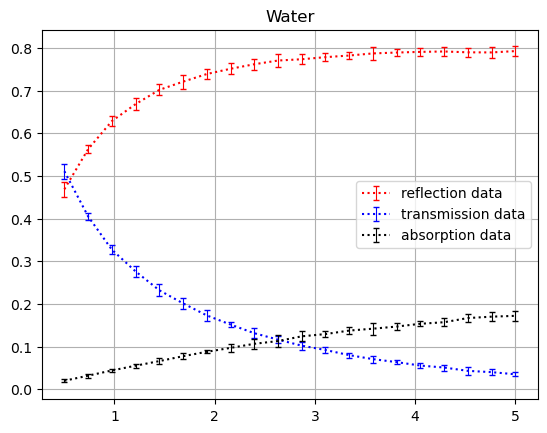

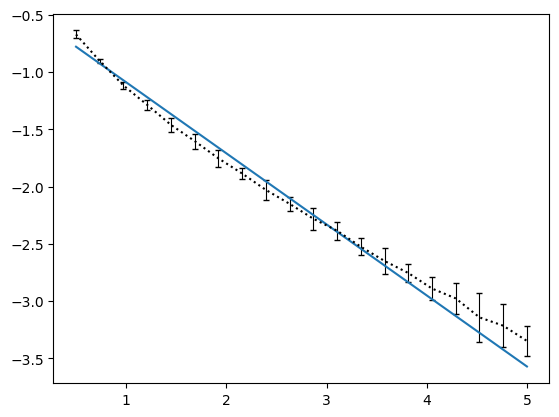

-----------------------------------------------
Transmission Through A Varied Thickness - Water
-----------------------------------------------
mean Free Path calculated as: 1.6115065417752779 ± 0.03953365402402365


In [20]:
L=5
N=10000
number=1
step_size=20
start=0.5

def calculating_mfp(L,N,number,step_size,start):
    """
    Calculates the mean free path (MFP) of neutrons through a material by simulating 
    their transmission through varying material thicknesses. The function fits a 
    linear model to the log-transformed transmission data to estimate the MFP.

    Parameters
    ----------
    L : float
        Maximum thickness of the material to simulate (cm).
    N : int
        Number of neutrons to simulate per run.
    number : int
        Index (1-based) of the material in `material_Objects` to simulate.
    step_size : int
        Number of steps (different thickness values) for the simulation.
    start : float
        Starting thickness for the material (cm).

    Returns
    -------
    None
        This function does not return values but prints the calculated mean free path 
        and its uncertainty. It also displays a plot showing the transmission data 
        with error bars and the fitted line.
    """
    averages,errors=repeating_for_different_lengths(L,N,number,material_Objects,step_size,start)
    #averages['t']/N=e^-(L/lambda)
    lengths=np.linspace(start, L, step_size)
    weights=averages/errors
    parameters,covr=np.polyfit(lengths,np.log(averages),w=weights,deg=1,cov=True)
    plt.subplots(1,1)
    plt.subplot(1,1,1)
    plt.errorbar(lengths,np.log(averages),1/weights,linestyle='dotted',capsize=2,elinewidth=0.8,color='k')
    # plt.plot(lengths,attenuation_lengths)
    plt.plot(lengths,parameters[0]*lengths+parameters[1])
    plt.show()
    slope=parameters[0]
    slope_uncertainty = np.sqrt(covr[0][0])  # Standard deviation of the slope
    mfp_uncertainty = slope_uncertainty / (slope**2)  # Uncertainty in MFP
    print('-----------------------------------------------')
    print('Transmission Through A Varied Thickness - {}'.format(material_Objects[number-1].writing_name()))
    print('-----------------------------------------------')
    print('mean Free Path calculated as: {} \u00B1 {}'.format(-1/slope, mfp_uncertainty))

calculating_mfp(L,N,number,step_size,start)

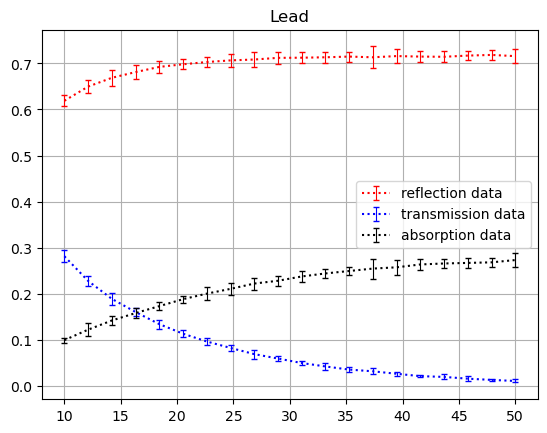

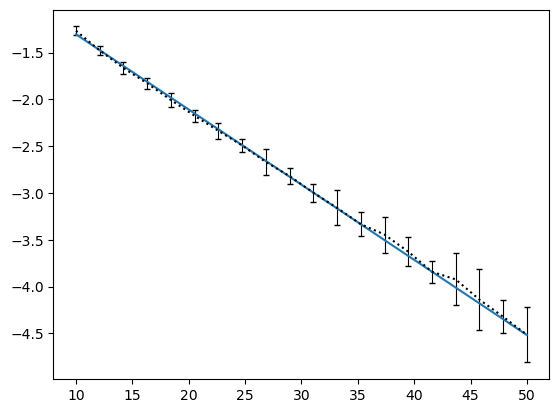

-----------------------------------------------
Transmission Through A Varied Thickness - Lead
-----------------------------------------------
mean Free Path calculated as: 12.455300815999541 ± 0.09138268166158234


In [21]:
L=50
N=10000
number=2
step_size=20
start=10
calculating_mfp(L,N,number,step_size,start)

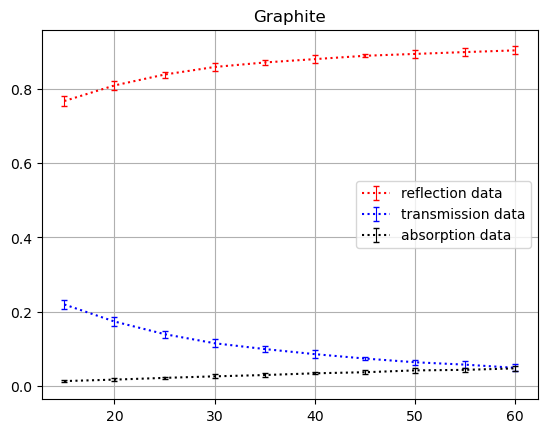

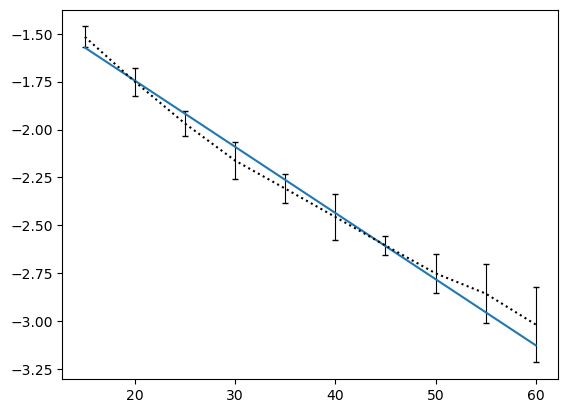

-----------------------------------------------
Transmission Through A Varied Thickness - Graphite
-----------------------------------------------
mean Free Path calculated as: 28.979090411684233 ± 1.0146856879444153


In [22]:
L=60
N=10000
number=3
step_size=10
start=15
calculating_mfp(L,N,number,step_size,start)